In [27]:
from torch_geometric.loader import DataLoader
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
torch.__version__

'1.11.0'

In [3]:
device = torch.device("cuda:0")
# device = torch.device("cpu")
device

device(type='cuda', index=0)

In [4]:
from utils_data import TestbedDataset
from models import GATNet_E, GATNet, GCNNet

In [5]:
model = GATNet()
model_path = 'root_folder/root_013/models/model_GAT-EP300-SW801010_GDSC.model'

# model = GCNNet()
# model_path = 'root_folder/root_003/models/model_GCN-EP300-SW801010_GDSC.model'
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)

GATNet(
  (gcn1): GATConv(334, 334, heads=10)
  (gcn2): GATConv(3340, 128, heads=1)
  (fc_g1): Linear(in_features=128, out_features=128, bias=True)
  (conv_xt_1): Conv1d(1, 32, kernel_size=(8,), stride=(1,))
  (pool_xt_1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv_xt_2): Conv1d(32, 64, kernel_size=(8,), stride=(1,))
  (pool_xt_2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv_xt_3): Conv1d(64, 128, kernel_size=(8,), stride=(1,))
  (pool_xt_3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc1_xt): Linear(in_features=2944, out_features=128, bias=True)
  (fc1): Linear(in_features=256, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [6]:
branch_folder = "root_folder/root_013"
dataset = 'GDSC'
test_data = TestbedDataset(root=branch_folder, dataset=dataset+'_test_mix')

Pre-processed data found: root_folder/root_013/processed/GDSC_test_mix.pt, loading ...


In [7]:
test_batch = 1
test_loader = DataLoader(test_data, batch_size=test_batch, shuffle=False)

In [9]:
i = 0
for data in test_loader:
    i += 1
    print(data)
    if i >= 5:
        break

DataBatch(x=[32, 334], edge_index=[2, 74], y=[1], edge_features=[74, 4], smiles=[1], drug_name=[1], cell_line_name=[1], target=[1, 735], c_size=[1], batch=[32], ptr=[2])
DataBatch(x=[27, 334], edge_index=[2, 60], y=[1], edge_features=[60, 4], smiles=[1], drug_name=[1], cell_line_name=[1], target=[1, 735], c_size=[1], batch=[27], ptr=[2])
DataBatch(x=[29, 334], edge_index=[2, 64], y=[1], edge_features=[64, 4], smiles=[1], drug_name=[1], cell_line_name=[1], target=[1, 735], c_size=[1], batch=[29], ptr=[2])
DataBatch(x=[37, 334], edge_index=[2, 80], y=[1], edge_features=[80, 4], smiles=[1], drug_name=[1], cell_line_name=[1], target=[1, 735], c_size=[1], batch=[37], ptr=[2])
DataBatch(x=[31, 334], edge_index=[2, 68], y=[1], edge_features=[68, 4], smiles=[1], drug_name=[1], cell_line_name=[1], target=[1, 735], c_size=[1], batch=[31], ptr=[2])


In [8]:
from torch_geometric.nn import GNNExplainer

In [15]:
# test one drug
one = next(iter(test_loader))
data = one.to(device)
print(data)

explainer = GNNExplainer(model, lr=1e-4, epochs=300, return_type='regression')

x = data.x
edge_index = data.edge_index
y = data.y
batch_drug = data.batch
edge_features = data.edge_features
x_cell_mut = data.target

# model_args = (
#     x_cell_mut,
#     batch_drug,
#     edge_features
# )

kwargs = {
    "x_cell_mut": x_cell_mut,
    "batch_drug": batch_drug,
    "edge_feat": edge_features
}

node_feature_mask, edge_mask = explainer.explain_graph(x = x, edge_index = edge_index, x_cell_mut = x_cell_mut, edge_feat = edge_features)
# node_feature_mask, edge_mask = explainer.explain_graph(x, edge_index, **kwargs)


DataBatch(x=[32, 334], edge_index=[2, 74], y=[1], edge_features=[74, 4], smiles=[1], drug_name=[1], cell_line_name=[1], target=[1, 735], c_size=[1], batch=[32], ptr=[2])


Explain graph: 100%|█████████████████████████| 300/300 [00:02<00:00, 109.19it/s]


- node_feature_mask: size = node feature length (334/...), importance of each node feature (inviriant of atoms)
- edge_mask: size = edge number, importance of edges, stored in the sequence of nodes (0,1),(0,5),(1,...

In [36]:
node_feature_mask

tensor([0.4976, 0.5065, 0.4914, 0.5239, 0.4937, 0.4706, 0.4806, 0.5110, 0.5185,
        0.4583, 0.5045, 0.4983, 0.5022, 0.5114, 0.4806, 0.4560, 0.5129, 0.5328,
        0.4364, 0.4887, 0.4795, 0.5035, 0.4957, 0.4973, 0.5128, 0.4705, 0.5133,
        0.4913, 0.4488, 0.5148, 0.4933, 0.4996, 0.4709, 0.4733, 0.4507, 0.5296,
        0.4383, 0.4841, 0.4949, 0.4847, 0.4479, 0.4458, 0.5031, 0.4738, 0.4706,
        0.5398, 0.4910, 0.5061, 0.4746, 0.4958, 0.4184, 0.4811, 0.4741, 0.5053,
        0.4454, 0.4759, 0.4729, 0.4903, 0.4830, 0.4988, 0.5272, 0.4588, 0.5004,
        0.4677, 0.5067, 0.4761, 0.4820, 0.4977, 0.5373, 0.5367, 0.5371, 0.5231,
        0.4874, 0.5167, 0.5347, 0.5282, 0.4927, 0.4444, 0.5399, 0.5167, 0.4499,
        0.4939, 0.5665, 0.4477, 0.4841, 0.5075, 0.4993, 0.5194, 0.5180, 0.4918,
        0.4828, 0.4890, 0.5111, 0.5411, 0.4678, 0.5339, 0.4773, 0.4944, 0.4839,
        0.4756, 0.5042, 0.4843, 0.5048, 0.4731, 0.4653, 0.4681, 0.4613, 0.4880,
        0.4995, 0.4966, 0.5282, 0.4785, 

In [21]:
edge_mask_cpu = edge_mask.to('cpu')
edge_index_cpu = edge_index.to('cpu')

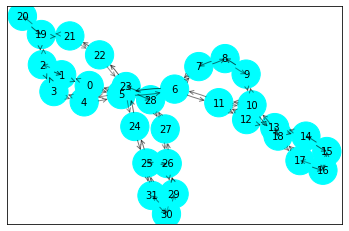

In [26]:
ax, G = explainer.visualize_subgraph(node_idx=None, edge_index=edge_index_cpu, edge_mask=edge_mask_cpu)
plt.show()

In [34]:
G[0]

AtlasView({1: {'att': 0.4867490530014038, 'edge_color': 'black'}, 5: {'att': 0.515681803226471, 'edge_color': 'black'}})

In [42]:
explainer = GNNExplainer(model, lr=1e-4, epochs=300)

for data in test_loader:
    x = data.x
    edge_index = data.edge_index
    y = data.y
    batch = data.batch
    edge_features = data.edge_features
    target = data.target
    
    node_feature_mask, edge_mask = explainer.explain_graph(x, edge_index, batch=batch, edge_feat = edge_features)
    ax, G = explainer.visualize_subgraph(edge_index, edge_mask, y=y)

TypeError: get_initial_prediction() got multiple values for keyword argument 'batch'